# Training Transformer Encoder


Today, we'll focus on Transformer Encoder and Self-Attention Mechanism.

## Step 0: Some imports and creating the data

In [59]:
# Imports
import os
import random
import numpy as np
import scipy as scp
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch import optim
from matplotlib import pyplot as plt
import matplotlib as mpl

# Set a seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Dataset Structure

First, let's create a data-generating function `make_data(N)` that produces `N` instances with the following characteristics:

- **Feature 0 (Energy Fraction):**  
  For each instance, a random subset of objects is selected to be "active."  
  - Class 0: 3 objects are activated with value $\frac{1}{3}$.  
  - Class 1: 5 objects are activated with value $\frac{1}{5}$.

- **Feature 1 (Pseudorapidity, η):**  
  Instead of assigning all instances from the same distribution, the pseudorapidity values are now generated based on the label:  
  - Class 0: Each object’s η is drawn uniformly from \([-3, 0]\).  
  - Class 1: Each object’s η is drawn uniformly from \([0, 3]\).

- **Feature 2 (Azimuthal angle, φ):**  
  Similarly, the azimuthal angle values are drawn from:  
  - Class 0: \([-π, 0]\).  
  - Class 1: \([0, π]\).


The function `make_data(N)` should return:
- A PyTorch feature tensor of shape `(N, 30, 3)` (where each object has 3 features).
- A PyTorch label tensor of shape `(N, 1)`.

This structure provides an analogous structure as **jet-like** data in particle physics.



In [95]:
def make_data(N):
    total = 30  # Number of objects per instance.
    
    # Initialize the feature tensor with zeros.
    # Shape: (N, 10, 3) where each object has 3 features.
    X = np.zeros((N, total, 3))
    
    # Randomly assign half of the instances to class 0.
    class0_idx = np.random.choice(np.arange(N), size=(N//2,), replace=False)
    labels = []  # To store the label for each instance.
    
    for i in range(N):
        if i in class0_idx:
            active = 3  # For class 0, 3 active objects.
            slots = np.random.choice(np.arange(total), size=(active,), replace=False)
            X[i, slots, 0] = 1/active  # Set energy fraction for these objects.
            # For class 0, sample pseudorapidity and azimuthal angle from the negative half of the range.
            X[i, :, 1] = np.random.uniform(-3, 0, size=(total,))
            X[i, :, 2] = np.random.uniform(-np.pi, 0, size=(total,))
            labels.append(0)
        else:
            active = 5  # For class 1, 5 active objects.
            slots = np.random.choice(np.arange(total), size=(active,), replace=False)
            X[i, slots, 0] = 1/active  # Set energy fraction for these objects.
            # For class 1, sample pseudorapidity and azimuthal angle from the positive half of the range.
            X[i, :, 1] = np.random.uniform(0, 3, size=(total,))
            X[i, :, 2] = np.random.uniform(0, np.pi, size=(total,))
            labels.append(1)
    
    labels = np.array(labels)

    
    # Return the feature tensor (N, 10, 3) and label tensor (N, 1) as PyTorch FloatTensors.
    return torch.FloatTensor(X), torch.FloatTensor(labels.reshape(-1, 1))

# Test the function with 100 instances.
X, y = make_data(100)
print("Feature tensor shape:", X.shape)  # Expected shape: (100, 10, 3)
print("Label tensor shape:", y.shape)      # Expected shape: (100, 1)


Feature tensor shape: torch.Size([100, 30, 3])
Label tensor shape: torch.Size([100, 1])


tensor([1.])


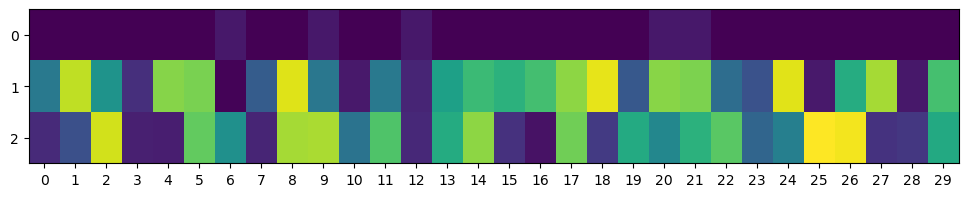

In [96]:
plt.figure(figsize=(12, 2))
plt.imshow(X[1].T, cmap='viridis', aspect='auto')
plt.xticks([i for i in range(30)])
print(y[1])
plt.show()

## Step 1: Implement Scaled Dot-Product Attention

In this step, you will implement the [scaled dot-product attention](https://paperswithcode.com/method/scaled) mechanism. In lecture, we learned about the scaled dot-product attention used in transformer models. The function $f$ is defined as the dot product between the linearly transformed query and keys using weight matrices $W_q$ and $W_k$:

$\tilde{\alpha}_i(t) = \frac{(W_q Q_t)^T (W_k K_i)}{\sqrt{d}},$

where $d$ is the dimension of the query. The normalized attention weights are computed by applying the softmax function:

$\alpha(t) = \text{softmax}\big(\tilde{\alpha}(t)\big)_i,$

Then, the context vector is computed as a weighted sum of the linearly transformed values:

$c_t = \sum_{i=1}^{T} \alpha(t)_i \, W_v V_i,$

where $W_v$ denotes the weight matrix that projects the value to produce the final context vectors.

---

#### Your Task

Implement the scaled dot-product attention mechanism by completing the `forward` method of the `ScaledDotAttention` class. Use PyTorch's `torch.bmm` (or the `@` operator) to compute the dot product between the batched queries and the batched keys, which gives you the unnormalized attention weights.

**Hints and Useful Functions:**

- `squeeze`
- `unsqueeze`
- `expand_as`
- `cat`
- `view`
- `bmm` (or `@`)

**Note:** Your forward pass should work with both:
- **2D query tensor:** Shape `(batch_size, 1, hidden_size)`
- **3D query tensor:** Shape `(batch_size, k, hidden_size)`

Be sure to handle both cases correctly.


In [24]:
class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()
        self.hidden_size = hidden_size
        
        # TODO: Define the weight matrices for query, key, and value.
        self.Wq = ...
        self.Wk = ...
        self.Wv = ...
    
    def forward(self, Q, K, V):
        """
        Compute the scaled dot-product attention.
        
        Args:
            Q (Tensor): Query tensor of shape (batch_size, k, hidden_size) or (batch_size, 1, hidden_size)
            K (Tensor): Key tensor of shape (batch_size, T, hidden_size)
            V (Tensor): Value tensor of shape (batch_size, T, hidden_size)
        
        Returns:
            context (Tensor): The context vectors after applying attention.
        """
        # TODO: Linearly transform Q, K, and V using the corresponding weight matrices.
        Q_trans = ...
        K_trans = ...
        V_trans = ...
        
        # Compute unnormalized attention scores using scaled dot-product.
        # Use torch.bmm or @ operator for batch matrix multiplication.
        # TODO: Fill in the computation of the dot product between Q_trans and the transpose of K_trans.
        scores = ..
        
        # Apply softmax to get the normalized attention weights.
        attn_weights = ...
        
        # Compute the context vectors as a weighted sum of the transformed values.
        context = ...
        
        return context, attn_weights


In [25]:
# Example to check your layer:
batch_size, T, hidden_size = 8, 30, 64
# For demonstration, create dummy tensors for Q, K, and V.
Q = torch.randn(batch_size, 1, hidden_size)  # 2D query tensor example.
K = torch.randn(batch_size, T, hidden_size)
V = torch.randn(batch_size, T, hidden_size)

attention_layer = ScaledDotAttention(hidden_size)
context, attn_weights = attention_layer(Q, K, V)
print("Context shape:", context.shape)  # Expected shape: (batch_size, 1, hidden_size)

Context shape: torch.Size([8, 1, 64])


## Step 2: Build a Transformer Encoder Model
In this step, you'll combine the ScaledDotAttention mechanism from Step 1 with a Transformer encoder layer, a pooling layer, and a prediction head for binary classification. Finally, you'll compare your Transformer model with an MLP and a DeepSet model you developed yesterday.

Your Transformer model will consist of:

1. **Input Projection:**  
   A linear layer that projects the input features (e.g. the 3 features from the jet dataset) into a hidden representation space.

2. **Transformer Encoder Layer:**  
   - **Self-Attention:** Use your ScaledDotAttention mechanism where the input serves as queries, keys, and values.
   - **Residual Connection and Layer Normalization:** Apply residual connections and layer normalization (PyTorch's `nn.LayerNorm`) after the attention and feed-forward sub-layers. (See the lectures)
   - **Feed-Forward Network:** A simple two-layer network with a ReLU activation in between, again followed by residual connection and layer normalization.

3. **Pooling Layer:**  
   After processing the sequence of objects (e.g., the 30 objects of each sample), pool the outputs along the sequence dimension. You can use average pooling (or sum pooling) to aggregate the per-object representations into a single vector.

4. **Prediction Head:**  
   A final linear layer with a sigmoid activation to produce a binary classification output.

#### **Question**:

What is the differnces between your Transformer Encder network and the one we had in the lecture (the original Atteention is All You Need paper) and Why?


In [31]:
# Transformer Encoder Layer with Residual Connections and Layer Normalization.
class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_size, ff_size):
        super(TransformerEncoderLayer, self).__init__()
        
        #TODO: call your ScaledDotAttention
        self.attention = ...
        #TODO: First Layer Norm
        self.layer_norm1 = ...
        
        # TODO: Feed-Forward Network
        self.feed_forward = nn.Sequential(
            ...
            ...
            ...
        )
        #TODO: Last layernorm
        self.layer_norm2 = ...
    
    def forward(self, x):
        # x shape: (batch_size, num_objects, hidden_size)
        # TODO: Self-attention: What are you Q, K, and V?
        attn_output, attn_weights = ...
        # TODO: Residual connection and 1st layer norm.
        x = ...
        
        # Feed-forward network.
        ff_output = self.feed_forward(x)
        # TODO: Residual connection and 2nd layer norm.
        x = ...
        return x, attn_weights

# Complete Transformer Model for Binary Classification.
class TransformerModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=8, ff_size=8):
        super(TransformerModel, self).__init__()
        # TODO: Project input features to hidden_size --> This is like your tokenizer
        self.input_proj = ...
        
        # Transformer encoder layer.
        self.encoder = TransformerEncoderLayer(hidden_size, ff_size)
        
        # TODO: Pooling layer: pooling over the objects (MIND THE DIMMENSION).
        self.pool = ...
        
        # TODO: Prediction head: a linear layer for binary classification.
        self.pred_head = nn.Sequential(
            ...
            ...
        )
    
    def forward(self, x):
        # x shape: (batch_size, num_objects, input_size)
        #TODO: apply your input projector 
        x = ...
        x, attn_weights = ...
        
        # TODO: Pooling over the sequence dimension.(HINT: Permute to shape (batch_size, hidden_size, num_objects) for pooling.)
        x_pooled = ...
        
        # TODO: Prediction head for binary classification.
        y = ...
        return y, attn_weights


In [32]:
# Example to check your layer:
batch_size = 32
num_objects = 30 
input_size = 3 
hidden_size = 8
ff_size = 8

# Create dummy data.
dummy_data = torch.randn(batch_size, num_objects, input_size)

# Initialize the Transformer model.
transformer_model = TransformerModel(input_size, hidden_size, ff_size)
output, attn_weights = transformer_model(dummy_data)
print("Transformer output shape:", output.shape)  # Expected: (batch_size, 1)

Transformer output shape: torch.Size([32, 1])


For the DeepSet, just use the following standard network architectures that you have already had in your past exercise:

In [51]:
class DeepSet(nn.Module):
    def __init__(self, agg_func):
        super(DeepSet, self).__init__()
        # Define the element-wise transformation network (psi)
        self.psi = nn.Sequential(
            nn.Linear(3, 8),  # Input from each element of the set (since ch=3)
            nn.Tanh(),
            nn.Linear(8, 8),
            nn.Tanh(),
            nn.Linear(8, 1)  # Output the transformed element
        )
        
        # Define the global set-wise network (phi)
        self.phi = nn.Sequential(
            nn.Linear(1, 8),  # Input is aggregated features from 30 elements
            nn.Tanh(),
            nn.Linear(8, 1),
            nn.Sigmoid()  # Binary classification
        )

        self.agg_func = agg_func  # new attribute for aggregation function

    def forward(self, x):
        # x shape: [bs, num_points, ch] where bs = batch size, num_points = 10, ch = 1
    
        # Apply psi to each element in the set independently
        x_transformed = self.psi(x)  # The psi network is applied element-wise #[100, 10, 1]

        if self.agg_func == 'max':
            x_pooled = x_transformed.max(dim=1)[0]  # Use max
        if self.agg_func == 'min':
            x_pooled = x_transformed.min(dim=1)[0]  # Use min
        if self.agg_func == 'mean':
            x_pooled = x_transformed.mean(dim=1)  # Use mean
        elif self.agg_func == 'std':
            x_pooled = x_transformed.std(dim=1)  # Use std
        else:
            x_pooled = x_transformed.sum(dim=1)  # Default to sum

        # Apply the global set-wise network phi
        y = self.phi(x_pooled)  # The phi network processes the aggregated features
        
        return y, _


### DeepSet vs Transformer

Now, do the training for your Transformer Model and the DeepSet and compare the losses

In [91]:
def train(model):
    # Create an optimizer object (Adam) with a learning rate of 1e-3.
    opt = torch.optim.Adam(model.parameters(), 1e-3)
    opt.zero_grad()
    
    # Initialize a list to store the loss values at each training step.
    trajectory = []
    num_iterations = 2000
    
    for i in range(num_iterations):
        # Generate a dataset on the fly with 100 samples.
        X, y = make_data(100)
        
        # Split the generated data: 80 samples for training, 20 for testing.
        n_train = int(0.8 * X.size(0))
        X_train, y_train = X[:n_train], y[:n_train]
        X_test, y_test = X[n_train:], y[n_train:]
        
        # --- Training on the train split ---
        model.train()  # Ensure the model is in training mode.
        p_train, attn_weights = model(X_train)
        loss = torch.nn.functional.binary_cross_entropy(p_train, y_train)
        
        # Record the training loss.
        trajectory.append(loss.item())
        
        # Backward pass: compute gradients and update model parameters.
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        # --- Evaluate on the test split every 500 iterations ---
        if i % 500 == 0:
            model.eval()  # Set model to evaluation mode.
            with torch.no_grad():
                p_test, _ = model(X_test)
                test_loss = torch.nn.functional.binary_cross_entropy(p_test, y_test)
            print(f"Iteration {i}: Train Loss = {loss.item():.4f}, Test Loss = {test_loss.item():.4f}")
            model.train()  # Switch back to training mode.
    
    # Return the trained model and the loss trajectory.
    return model, np.array(trajectory)

In [92]:
trained_transformer, losscurve_transformer = train(TransformerModel())
print('Training Transformer is Finished!')
trained_deepset, losscurve_deepset = train(DeepSet(agg_func='sum'))
print('Training DeepSet is Finished!')

Iteration 0: Train Loss = 1.3000, Test Loss = 1.2512
Iteration 500: Train Loss = 0.0277, Test Loss = 0.0276
Iteration 1000: Train Loss = 0.0065, Test Loss = 0.0065
Iteration 1500: Train Loss = 0.0025, Test Loss = 0.0025
Training Transformer is Finished!
Iteration 0: Train Loss = 0.7759, Test Loss = 0.8205
Iteration 500: Train Loss = 0.0535, Test Loss = 0.0537
Iteration 1000: Train Loss = 0.0186, Test Loss = 0.0186
Iteration 1500: Train Loss = 0.0095, Test Loss = 0.0094
Training DeepSet is Finished!


In [81]:
def count_params(model):
    return sum([p.numel() for p in model.parameters()])

n_transformer = count_params(trained_transformer)
n_deepset = count_params(trained_deepset)

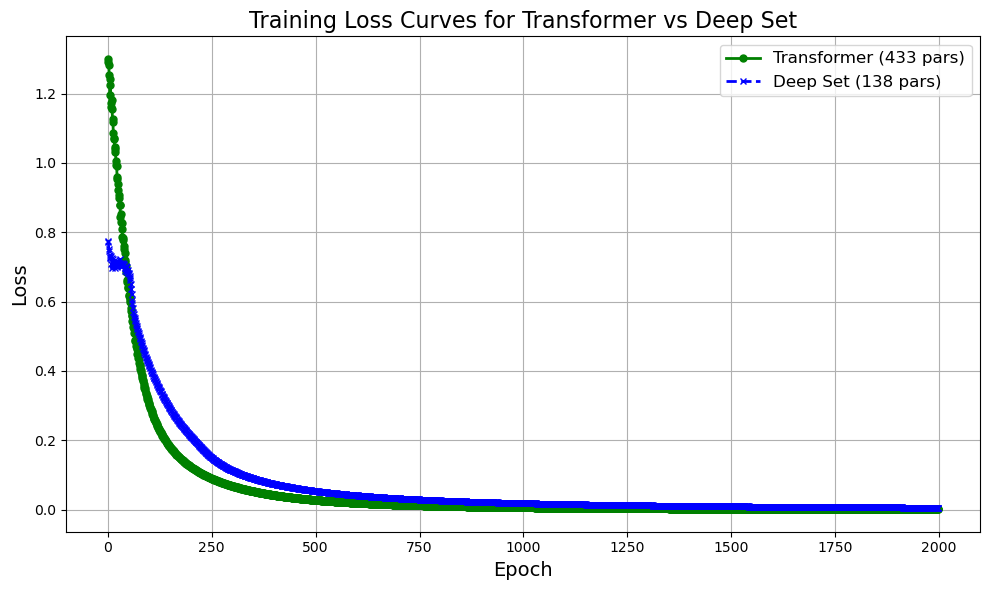

In [94]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(losscurve_transformer, label=f'Transformer ({n_transformer} pars)', color='green', linestyle='-', linewidth=2, marker='o', markersize=5)
plt.plot(losscurve_deepset, label=f'Deep Set ({n_deepset} pars)', color='blue', linestyle='--', linewidth=2, marker='x', markersize=5)
plt.title('Training Loss Curves for Transformer vs Deep Set', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 2: Visualizing and Interpreting Attention Weights

Now that you've trained your models, it's time to explore what the Transformer model has learned. In this step, you'll visualize the attention weights computed by your Transformer encoder layer and interpret them. Understanding the attention weights can provide insight into which parts of the input the model is focusing on during prediction.


#### Objectives

- **Extract Attention Weights:**  
  Retrieve the attention weights from the Transformer model’s forward pass.

- **Visualize Attention Weights:**  
  Use a heatmap (or similar visualization) to display the attention weights for a given input instance or a batch of instances.

- **Interpretation:**  
  Analyze the heatmap to understand which objects (or "particles") in each instance the model attends to most. Discuss possible reasons behind the observed attention patterns, and how they may relate to the different classes.


#### Exercise Instructions

1. **Run the Trained Model on a Batch of Data:**
   - Use the trained Transformer model to perform a forward pass on a batch of input data (e.g., using `make_data`).
   - Retrieve both the predictions and the corresponding attention weights from the model.

2. **Select a Sample for Visualization:**
   - Choose one instance from the batch to visualize. Note the shape of the attention weight tensor—it will have the shape `[batch_size, k, T]` (where `k` is the query dimension and `T` is the number of objects).

3. **Plot the Attention Weights:**
   - Use `matplotlib` to create a heatmap of the attention weights.  

4. **Interpret the Results:**
   - Write a short paragraph discussing what you observe. For example:
     - Do certain objects consistently receive higher weights?
     - How might these attention patterns correlate with the different classes in your dataset?
     - What do the attention distributions suggest about how the model is processing the input set?
     - Are there patterns that differ between class 0 and class 1 instances?

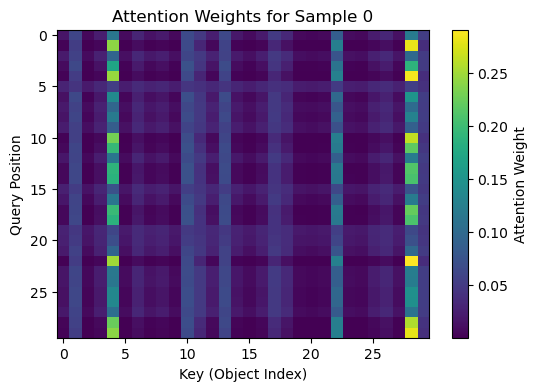

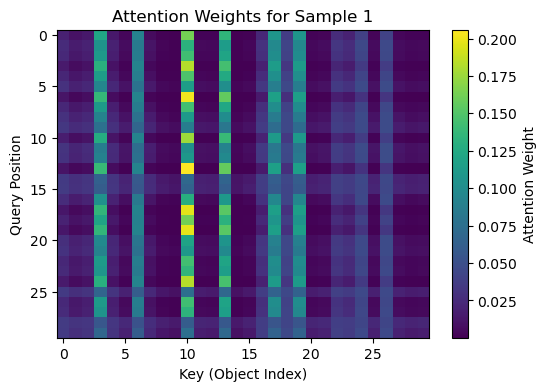

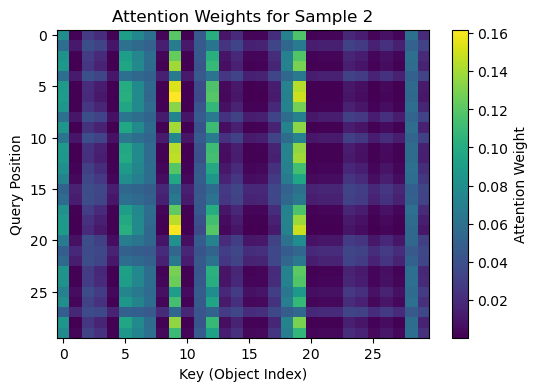

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.]])


In [93]:
# Generate a small batch of data for visualization.
X, y = make_data(10)  # Using 10 instances for example.

# TODO: Pass the data through the model and Convert attention weights to numpy for plotting
...
predictions, attn_weights = ...
attn_np = ...

print(y.T)
# Visualize the attention weights for a few samples.
for idx in range(10):
...
    plt.colorbar(label='Attention Weight')
    plt.show()
